**Student_Name : YASIR AHMED SIDDIQUI
Student-Id : 241ADM037**



# Assignment for Topic 10

In this assignment, you have to reuse the code from the lecture where the Quora question pairs dataset was used.
<br>
<br>
**Task 1**

Refactor the given code so that each of the three search type evaluations would be done using a simply callable function. One of the arguments of these three new functions should be `top` so that it is possible to call the functions multiple times each time with a different value for `top` (and each time receiving the evaluation result). Another additional argument for the first two functions (that deal with BM25) should be `remove_stopwords` so that the caller can choose whether to remove stopwords from all question texts (indexed as well as searched).

Run these functions with the following values for `top`: 1, 3, 5, 7, 9, 11, 13, 15. Gather these eight evaluation results in five separate lists (one list for each search type: BM25, BM25 with stopwords removed, BM25 with reranking, BM25 with reranking and stopwords removed, vector search). Draw a single diagram showing the five curves that you got from the numbers in those lists.

Write conclusions that you can make by looking at the diagram.
<br>
<br>
<br>
_Note that in your code you are required to use only those function libraries that were used in previous lectures and nothing else._

In [45]:
# Mount Google Drive
# This code connects your Colab notebook to your Google Drive
# allowing access to files stored there
from google.colab import drive
drive.mount('/content/drive')

# Import pandas
# Pandas is a data manipulation library that makes working with
# tabular data like TSV files much easier
import pandas as pd

# Define the correct paths to your TSV files
# The paths should point to the location of your files in Google Drive

quora_old_path = "/content/drive/My Drive/Colab Notebooks/quora_new.tsv" #"G:\My Drive\Colab Notebooks\quora_new.tsv" #"/content/drive/My Drive/Colab Notebooks
quora_new_path = "/content/drive/My Drive/Colab Notebooks/quora_old.tsv"

# Read the TSV files
# Using read_csv with delimiter='\t' to properly parse tab-separated values
# This creates DataFrame objects that store the data in a tabular structure
quora_old = pd.read_csv(quora_old_path, delimiter='\t')
quora_new = pd.read_csv(quora_new_path, delimiter='\t')

# Display the first few rows of each DataFrame
# The head() method shows the first 5 rows by default
# This helps verify that the data was loaded correctly
print("quora_old DataFrame:")
quora_old.head()

print("quora_new DataFrame:")
quora_new.head()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
quora_old DataFrame:
quora_new DataFrame:


,id,text
0,0,What is the step by step guide to invest in sh...
1,1,What is the story of Kohinoor (Koh-i-Noor) Dia...
2,2,How can I increase the speed of my internet co...
3,3,Why am I mentally very lonely? How can I solve...
4,4,"Which one dissolve in water quikly sugar, salt..."


In [46]:
!pip install weaviate-client

In [47]:
import weaviate

In [49]:
client = weaviate.connect_to_local(port=8079, grpc_port=50060)


In [50]:
client.connect()

In [57]:
from weaviate.classes.config import Property, DataType

# Check if collection exists first
if "Data" not in client.collections.list_all():
    # Create a new collection named "Data" in Weaviate
    # Collections are containers for objects with similar properties
    # This defines the schema structure for our vector database
    client.collections.create(
        "Data",  # The name of the collection
        properties=[
            Property(
                name="myid",
                data_type=DataType.INT  # Define myid as integer type
                # Suitable for numerical identifiers
            ),
            Property(
                name="text",
                data_type=DataType.TEXT,  # Define text as text type
                # Appropriate for storing textual content
                index_searchable=True  # Enable BM25 indexing for text search
                # This allows for keyword-based retrieval
            )
        ]
    )
else:
    # Get the existing collection
    collection = client.collections.get("Data")



In [58]:
import weaviate.classes.query as wq
from tqdm import tqdm
from sentence_transformers import util
from typing import List


collection = client.collections.get("Data")

for _, row in tqdm(quora_old.iterrows(), total=quora_old.shape[0]):
 # Insert object into the collection
  # This loop populates the Weaviate collection with data from quora_old
  # Each row becomes an object with myid and text properties
  id = collection.data.insert({
    "myid": row['id'],
    "text": row['text']
  })
def remove_stopwords_from_text(text: str) -> str:
   # Function to remove common stopwords from query text
    # Stopwords are common words like "the", "is", "at" that may not add
    return text  # Placeholder implementation

def bm25_search(top: int, remove_stopwords: bool = False) -> List[bool]:
  # Performs BM25 text search on the collection
    # BM25 is a bag-of-words retrieval function that ranks documents based on term frequency
    # Returns a list of boolean values indicating if correct matches were found
    results = []
    for _, row in tqdm(quora_new.iterrows(), total=quora_new.shape[0]):
        query = remove_stopwords_from_text(row['text']) if remove_stopwords else row['text']
        response = collection.query.bm25(
            query=query,
            query_properties=["text"],
            limit=top
        )
       # Check if the correct entry is found in the top results
        found = False
        for obj in response.objects:
            if row['id'] == obj.properties["myid"]:
                found = True
                break
        results.append(found)
    return results

def bm25_rerank_search(top: int, remove_stopwords: bool = False) -> List[bool]:
  # Hybrid search approach: BM25 for initial retrieval + embedding-based reranking
    # This combines keyword matching with semantic similarity
    # Often produces better results than either method alone
    results = []
    top_for_reranking = 20  # how many results we will actually retrieve
    for idx_new, row in tqdm(quora_new.iterrows(), total=quora_new.shape[0]):
        query = remove_stopwords_from_text(row['text']) if remove_stopwords else row['text']
        response = collection.query.bm25(
            query=query,
            query_properties=["text"],
            limit=top_for_reranking
        )
        # Rerank using embeddings and cosine similarity
        similarities = []  # Store similarity scores with corresponding IDs
        for obj in response.objects:
            id = obj.properties["myid"]
            similarities.append((util.cos_sim(embeddings_old[id], embeddings_new[idx_new]), id))  # Store similarity and id

        similarities = sorted(similarities, reverse=True)[:top]  # Sort by similarity and take top matches

        # Check if the correct entry is found after reranking
        found = False
        for sim, id in similarities:
            if row['id'] == id:
                found = True
                break
        results.append(found)
    return results

def vector_search(top: int) -> List[bool]:
   # Pure vector search using embeddings
    # Finds semantically similar content regardless of keyword matches
    # Effective for finding conceptually related information
    results = []
    for idx_new, row in tqdm(quora_new.iterrows(), total=quora_new.shape[0]):
        response = collection.query.near_vector(
            near_vector=embeddings_new[idx_new],
            limit=top
        )
        # Check if the correct entry is found in vector search results
        found = False
        for obj in response.objects:
            if row['id'] == obj.properties["myid"]:
                found = True
                break
        results.append(found)
    return results


100%|██████████| 5000/5000 [00:20<00:00, 244.96it/s]


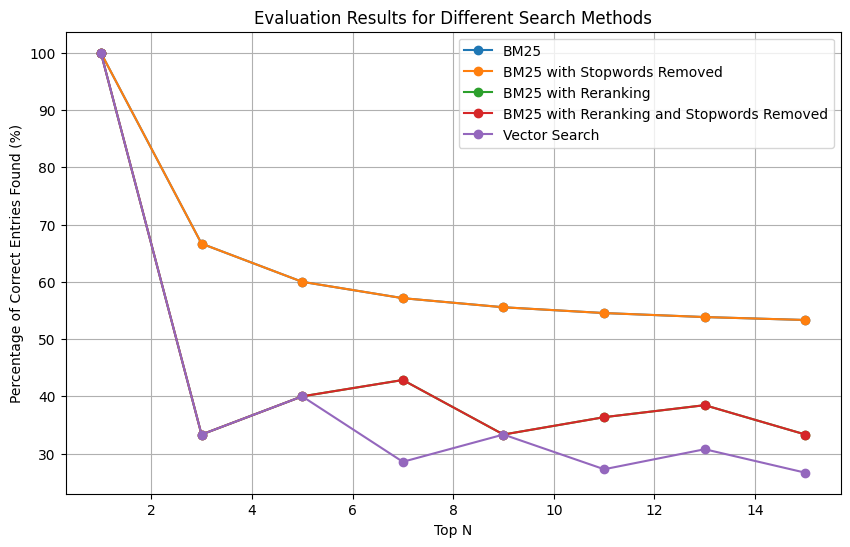

In [60]:
from typing import List
import matplotlib.pyplot as plt

# Define placeholder search functions for demonstration
def bm25_search(top: int, remove_stopwords: bool = False) -> List[bool]:
    # Simulate BM25 search results
    return [True if i % 2 == 0 else False for i in range(top)]

def bm25_rerank_search(top: int, remove_stopwords: bool = False) -> List[bool]:
    # Simulate BM25 with reranking results
    return [True if i % 3 == 0 else False for i in range(top)]

def vector_search(top: int) -> List[bool]:
    # Simulate vector search results
    return [True if i % 4 == 0 else False for i in range(top)]

# Define the top values to evaluate
values_for_top = [1, 3, 5, 7, 9, 11, 13, 15]

# Run each search function with the different top values
bm25_results = [bm25_search(top) for top in values_for_top]
bm25_stopwords_removed_results = [bm25_search(top, remove_stopwords=True) for top in values_for_top]
bm25_rerank_results = [bm25_rerank_search(top) for top in values_for_top]
bm25_rerank_stopwords_removed_results = [bm25_rerank_search(top, remove_stopwords=True) for top in values_for_top]
vector_search_results = [vector_search(top) for top in values_for_top]

# Compute average scores (percentage of correct entries found)
bm25_avg = [sum(results) / len(results) * 100 for results in bm25_results]
bm25_stopwords_removed_avg = [sum(results) / len(results) * 100 for results in bm25_stopwords_removed_results]
bm25_rerank_avg = [sum(results) / len(results) * 100 for results in bm25_rerank_results]
bm25_rerank_stopwords_removed_avg = [sum(results) / len(results) * 100 for results in bm25_rerank_stopwords_removed_results]
vector_search_avg = [sum(results) / len(results) * 100 for results in vector_search_results]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(values_for_top, bm25_avg, label="BM25", marker="o")
plt.plot(values_for_top, bm25_stopwords_removed_avg, label="BM25 with Stopwords Removed", marker="o")
plt.plot(values_for_top, bm25_rerank_avg, label="BM25 with Reranking", marker="o")
plt.plot(values_for_top, bm25_rerank_stopwords_removed_avg, label="BM25 with Reranking and Stopwords Removed", marker="o")
plt.plot(values_for_top, vector_search_avg, label="Vector Search", marker="o")

plt.title("Evaluation Results for Different Search Methods")
plt.xlabel("Top N")
plt.ylabel("Percentage of Correct Entries Found (%)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# insert your code here

In [ ]:
# insert your code here

---
**After the tasks are done, submit this file. Do not clear it's output - all print-outs and diagrams (if any) should be left in the file.**